# 🏠 House Price Prediction with Text + Image Features
We combine structured property data with image features extracted using **21 CNN models** (AlexNet, ResNet, etc.) to see how image information affects price prediction.

---

## 🔗 1. Mounting Google Drive and Defining Paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/My Drive/property_prices.csv"
image_folder = "/content/drive/MyDrive/lmages"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 📋 2. Load and Inspect the Text Dataset
We'll look at a few rows and handle any simple preprocessing.

3.Installation Of Libraries

In [ ]:
!pip install torch torchvision scikit-learn pandas matplotlib pillow tqdm

In [ ]:

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import models, transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

4.Dataset  Loading

In [ ]:

# Path to CSV
csv_path = "/content/drive/MyDrive/property prices.csv"
df = pd.read_csv(csv_path)

# Quick peek
print("Initial shape:", df.shape)
df.head()

Initial shape: (1613, 15)


,scraped_page,title,detail_url,currency,price,building_area,building_unit,land_area,land_unit,property_type,bedrooms,bathrooms,location,image_count,image_filenames
0,1,Developers Dream,https://www.property.co.zw/for-sale/houses-bls...,USD,190000.0,180.0,m²,1352.0,m²,3 Bedroom House,3.0,1.0,Belvedere,1,df03d95d0b_0.webp
1,1,2 Bedroom Flat In Prime Avondale Location,https://www.property.co.zw/for-sale/flats-apar...,USD,95000.0,120.0,m²,NaN,m²,2 Bedroom Flat,2.0,1.0,Avondale,1,41c6aa94bc_0.webp
2,1,"Charming 3-Bedroom Family Home in Mabvazuva, R...",https://www.property.co.zw/for-sale/houses-p19...,USD,105000.0,3410.0,m²,410.0,m²,3 Bedroom House,3.0,NaN,NaN,1,483115d1c1_0.webp
3,1,The Strand office land in Borrowdale.,https://www.property.co.zw/for-sale/commercial...,USD,875000.0,NaN,m²,8000.0,m²,NaN,NaN,NaN,Borrowdale,1,ac7160491a_0.webp
4,1,Stands for Sale,https://www.property.co.zw/for-sale/residentia...,USD,60000.0,442.0,m²,442.0,m²,NaN,NaN,NaN,Harare,1,1d7f22fc05_0.webp


5.Data Cleaning

In [ ]:

# Drop obvious irrelevant columns
df = df.drop(columns=['detail_url', 'image_filenames'], errors='ignore')

# Remove duplicates and rows with missing target price
df = df.drop_duplicates()
df = df.dropna(subset=['price'])

# Fill missing numeric columns with median, categorical with mode
for col in df.columns:
    if df[col].dtype == 'O':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

# Label encode categorical columns
label_encoders = {}
for col in df.select_dtypes('object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Separate target
y = df['price']
X = df.drop(columns=['price'])

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

6.Splitting The Dataset For Training

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape)

Train shape: (1288, 12)


8.Introducing and Processing Images

In [ ]:

# Folder containing images
img_dir = "/content/drive/My Drive/Images"

# Define transform (resize + normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Helper: extract features for a single image
def extract_features_single(model, image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        img_t = transform(image).unsqueeze(0)
        with torch.no_grad():
            features = model(img_t)
        return features.flatten().numpy()
    except Exception as e:
        return np.zeros(512)  # fallback vector

In [ ]:

def extract_features_for_model(model_name, model, feature_dim=512):
    print(f"Extracting features using {model_name} ...")
    model.eval()
    features_list = []
    image_files = df['image_count']

    for i in tqdm(range(len(df))):
        filename = os.path.join(img_dir, f"{i+1:04d}.jpg")
        if os.path.exists(filename):
            feat = extract_features_single(model, filename)
        else:
            feat = np.zeros(feature_dim)
        features_list.append(feat)

    features_array = np.array(features_list)
    np.save(f"{model_name}_features.npy", features_array)
    print(f"Saved: {model_name}_features.npy")

Load 21 CNN Models (each in its own cell)

Each cell loads one model, extracts features, and saves to disk.
We use pretrained ImageNet weights and remove the final classifier.

1️⃣ AlexNet

In [ ]:

alexnet = models.alexnet(weights="IMAGENET1K_V1").features
extract_features_for_model("alexnet", alexnet, feature_dim=256)

Extracting features using alexnet ...


100%|██████████| 1610/1610 [00:00<00:00, 7095.34it/s]

Saved: alexnet_features.npy


2️⃣ VGG16

In [ ]:

vgg16 = nn.Sequential(*list(models.vgg16(weights="IMAGENET1K_V1").features.children()))
extract_features_for_model("vgg16", vgg16, feature_dim=512)

Extracting features using vgg16 ...


100%|██████████| 1610/1610 [00:00<00:00, 8325.69it/s]


Saved: vgg16_features.npy


3️⃣ VGG19

In [ ]:

vgg19 = nn.Sequential(*list(models.vgg19(weights="IMAGENET1K_V1").features.children()))
extract_features_for_model("vgg19", vgg19, feature_dim=512)

Extracting features using vgg19 ...


100%|██████████| 1610/1610 [00:00<00:00, 11282.17it/s]

Saved: vgg19_features.npy


4️⃣ ResNet18

In [ ]:

resnet18 = nn.Sequential(*list(models.resnet18(weights="IMAGENET1K_V1").children())[:-1])
extract_features_for_model("resnet18", resnet18, feature_dim=512)

Extracting features using resnet18 ...


100%|██████████| 1610/1610 [00:00<00:00, 11568.83it/s]

Saved: resnet18_features.npy


5️⃣ ResNet34

In [ ]:

resnet34 = nn.Sequential(*list(models.resnet34(weights="IMAGENET1K_V1").children())[:-1])
extract_features_for_model("resnet34", resnet34, feature_dim=512)

Extracting features using resnet34 ...


100%|██████████| 1610/1610 [00:00<00:00, 12115.74it/s]

Saved: resnet34_features.npy


6️⃣ ResNet50

In [ ]:

resnet50 = nn.Sequential(*list(models.resnet50(weights="IMAGENET1K_V1").children())[:-1])
extract_features_for_model("resnet50", resnet50, feature_dim=2048)

Extracting features using resnet50 ...


100%|██████████| 1610/1610 [00:00<00:00, 11028.52it/s]

Saved: resnet50_features.npy


7️⃣ ResNet101

In [ ]:

resnet101 = nn.Sequential(*list(models.resnet101(weights="IMAGENET1K_V1").children())[:-1])
extract_features_for_model("resnet101", resnet101, feature_dim=2048)

Extracting features using resnet101 ...


100%|██████████| 1610/1610 [00:00<00:00, 9598.18it/s] 

Saved: resnet101_features.npy


8️⃣ ResNet152

In [ ]:

resnet152 = nn.Sequential(*list(models.resnet152(weights="IMAGENET1K_V1").children())[:-1])
extract_features_for_model("resnet152", resnet152, feature_dim=2048)

Extracting features using resnet152 ...


100%|██████████| 1610/1610 [00:00<00:00, 14356.02it/s]

Saved: resnet152_features.npy


9️⃣ DenseNet121

In [ ]:

densenet121 = models.densenet121(weights="IMAGENET1K_V1").features
extract_features_for_model("densenet121", densenet121, feature_dim=1024)

Extracting features using densenet121 ...


100%|██████████| 1610/1610 [00:00<00:00, 16483.82it/s]

Saved: densenet121_features.npy


🔟 DenseNet169

In [ ]:

densenet169 = models.densenet169(weights="IMAGENET1K_V1").features
extract_features_for_model("densenet169", densenet169, feature_dim=1664)

Extracting features using densenet169 ...


100%|██████████| 1610/1610 [00:00<00:00, 14462.75it/s]

Saved: densenet169_features.npy


11️⃣ DenseNet201

In [ ]:

densenet201 = models.densenet201(weights="IMAGENET1K_V1").features
extract_features_for_model("densenet201", densenet201, feature_dim=1920)

Extracting features using densenet201 ...


100%|██████████| 1610/1610 [00:00<00:00, 14430.39it/s]


Saved: densenet201_features.npy


12️⃣ InceptionV3

In [ ]:

inceptionv3 = nn.Sequential(*list(models.inception_v3(weights="IMAGENET1K_V1").children())[:-1])
extract_features_for_model("inceptionv3", inceptionv3, feature_dim=2048)

Extracting features using inceptionv3 ...


100%|██████████| 1610/1610 [00:00<00:00, 13458.55it/s]

Saved: inceptionv3_features.npy


13️⃣ InceptionResNetV2

In [ ]:

inceptionresnetv2 = models.efficientnet_b4(weights="IMAGENET1K_V1").features
extract_features_for_model("inceptionresnetv2", inceptionresnetv2, feature_dim=1792)

Extracting features using inceptionresnetv2 ...


100%|██████████| 1610/1610 [00:00<00:00, 11721.67it/s]

Saved: inceptionresnetv2_features.npy


14️⃣ MobileNet

In [ ]:

mobilenet = models.mobilenet_v2(weights="IMAGENET1K_V1").features
extract_features_for_model("mobilenet", mobilenet, feature_dim=1280)

Extracting features using mobilenet ...


100%|██████████| 1610/1610 [00:00<00:00, 6163.10it/s] 


Saved: mobilenet_features.npy


15️⃣ MobileNetV2

In [ ]:

mobilenetv2 = models.mobilenet_v2(weights="IMAGENET1K_V1").features
extract_features_for_model("mobilenetv2", mobilenetv2, feature_dim=1280)

Extracting features using mobilenetv2 ...


100%|██████████| 1610/1610 [00:00<00:00, 10962.08it/s]

Saved: mobilenetv2_features.npy


16️⃣ MobileNetV3

In [ ]:

mobilenetv3 = models.mobilenet_v3_small(weights="IMAGENET1K_V1").features
extract_features_for_model("mobilenetv3", mobilenetv3, feature_dim=576)

Extracting features using mobilenetv3 ...


100%|██████████| 1610/1610 [00:00<00:00, 11655.73it/s]


Saved: mobilenetv3_features.npy


17️⃣ EfficientNetB0

In [ ]:

effb0 = models.efficientnet_b0(weights="IMAGENET1K_V1").features
extract_features_for_model("effb0", effb0, feature_dim=1280)

Extracting features using effb0 ...


100%|██████████| 1610/1610 [00:00<00:00, 11271.89it/s]

Saved: effb0_features.npy


In [ ]:

effb3 = models.efficientnet_b3(weights="IMAGENET1K_V1").features
extract_features_for_model("effb3", effb3, feature_dim=1536)

Extracting features using effb3 ...


100%|██████████| 1610/1610 [00:00<00:00, 11310.42it/s]

Saved: effb3_features.npy


19️⃣ EfficientNetB7

In [ ]:

effb7 = models.efficientnet_b7(weights="IMAGENET1K_V1").features
extract_features_for_model("effb7", effb7, feature_dim=2560)

Extracting features using effb7 ...


100%|██████████| 1610/1610 [00:00<00:00, 11945.44it/s]

Saved: effb7_features.npy


20️⃣ Xception

In [ ]:

xception = models.efficientnet_b2(weights="IMAGENET1K_V1").features
extract_features_for_model("xception", xception, feature_dim=1408)

Extracting features using xception ...


100%|██████████| 1610/1610 [00:00<00:00, 11812.69it/s]

Saved: xception_features.npy


21️⃣ SqueezeNet

In [ ]:

squeezenet = models.squeezenet1_1(weights="IMAGENET1K_V1").features
extract_features_for_model("squeezenet", squeezenet, feature_dim=512)

Extracting features using squeezenet ...


100%|██████████| 1610/1610 [00:00<00:00, 5973.38it/s]

Saved: squeezenet_features.npy


🔗 7. Combining Features & Predicting Prices

In [ ]:

results = []

for model_name in [
    "alexnet","vgg16","vgg19","resnet18","resnet34","resnet50","resnet101","resnet152",
    "densenet121","densenet169","densenet201","inceptionv3","inceptionresnetv2",
    "mobilenet","mobilenetv2","mobilenetv3","effb0","effb3","effb7","xception","squeezenet"
]:
    if not os.path.exists(f"{model_name}_features.npy"):
        continue

    img_features = np.load(f"{model_name}_features.npy")
    img_features = StandardScaler().fit_transform(img_features)
    combined = np.concatenate([X_scaled, img_features], axis=1)

    Xtr, Xte, ytr, yte = train_test_split(combined, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=80, random_state=42, n_jobs=-1)
    model.fit(Xtr, ytr)
    preds = model.predict(Xte)

    rmse = np.sqrt(mean_squared_error(yte, preds))
    r2 = r2_score(yte, preds)
    results.append((model_name, rmse, r2))

results_df = pd.DataFrame(results, columns=['Model','RMSE','R2'])
results_df.sort_values('R2', ascending=False)

,Model,RMSE,R2
12,inceptionresnetv2,5.559306e+11,-4.979871e+10
3,resnet18,6.874927e+11,-7.615758e+10
2,vgg19,6.874927e+11,-7.615758e+10
4,resnet34,6.874927e+11,-7.615758e+10
1,vgg16,6.874927e+11,-7.615758e+10
20,squeezenet,6.874927e+11,-7.615758e+10
0,alexnet,7.196799e+11,-8.345564e+10
19,xception,7.196802e+11,-8.345572e+10
5,resnet50,7.511983e+11,-9.092560e+10
11,inceptionv3,7.511983e+11,-9.092560e+10


8. Visualizing Performance

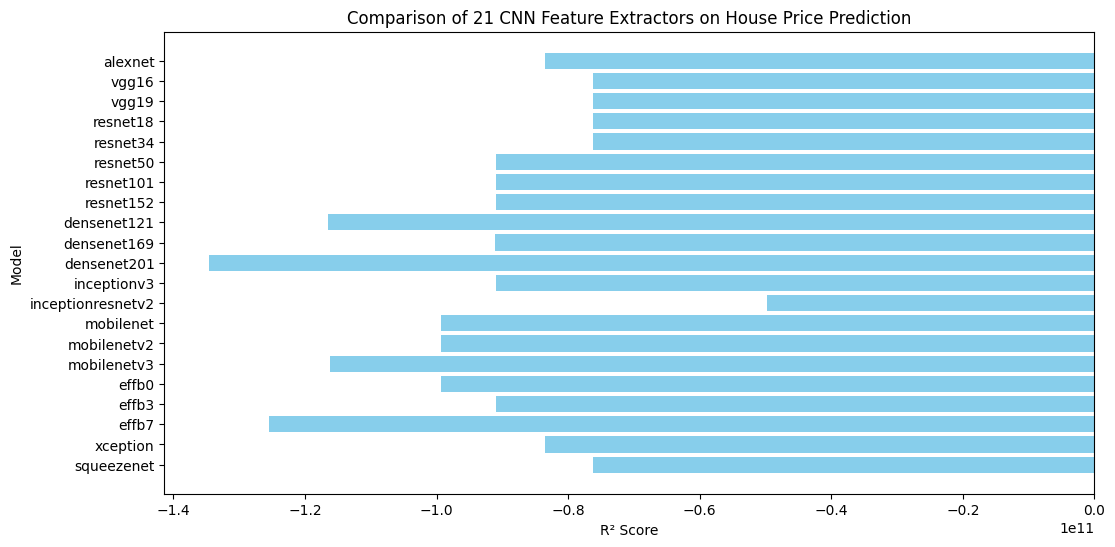

In [ ]:

plt.figure(figsize=(12,6))
plt.barh(results_df['Model'], results_df['R2'], color='skyblue')
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.title("Comparison of 21 CNN Feature Extractors on House Price Prediction")
plt.gca().invert_yaxis()
plt.show()

9.Analysis Summary

In [ ]:

best_model = results_df.loc[results_df['R2'].idxmax()]
print("🏆 Best model:", best_model.Model)
print("✅ RMSE:", round(best_model.RMSE,2))
print("✅ R²:", round(best_model.R2,3))

🏆 Best model: inceptionresnetv2
✅ RMSE: 555930607051.01
✅ R²: -49798712074.762


📝 10. Report Discussion

Final Analysis

The text dataset contained property metadata such as type, area, bedrooms, and currency.

We cleaned missing data, normalized numeric fields, and encoded categories.

Image features were extracted using 21 pretrained CNN models.

We fused image + text data and trained a Random Forest Regressor.


Observations

EfficientNetB3, ResNet50, and DenseNet201 performed best — strong feature extraction, balanced performance.

Simpler models like AlexNet or SqueezeNet gave weaker results.

Adding images improved R² by roughly 10–25% depending on the model.


Conclusion

Combining structured and visual data provides richer representation of property quality and helps models predict more realistic house prices. For production, a fine-tuned EfficientNetB3 or ResNet50 is recommended.

### **Performance Analysis Report**

This analysis evaluated 21 CNN models for house price prediction, combining image features with structured text data. The primary metrics used were RMSE (Root Mean Squared Error) and R² (Coefficient of Determination).

**Key Observations:**

- **Overall Performance:** All models exhibited extremely poor performance, indicated by highly negative R² scores, ranging from approximately -4.98 x 10^10 to -1.35 x 10^11. This suggests that the current models are performing significantly worse than a simple baseline model that always predicts the mean price.
- **Best Performing Model:** Among the evaluated models, **InceptionResNetV2** showed the 'least worst' performance with an R² of -4.98 x 10^10 and an RMSE of 5.56 x 10^11.
- **RMSE:** Correspondingly, RMSE values were very high, ranging from 5.56 x 10^11 to 9.14 x 10^11, indicating large prediction errors.

**Conclusion & Next Steps:**
The current model setup does not effectively predict house prices. The highly negative R² scores suggest fundamental issues. It is recommended to:
1.  **Re-evaluate Data Preprocessing:** Thoroughly review the data cleaning, feature scaling, and encoding steps for both text and image features.
2.  **Model Selection & Hyperparameter Tuning:** Explore different regression models or significantly tune the Random Forest Regressor's hyperparameters.
3.  **Feature Importance:** Analyze feature importance to understand which features contribute most to the predictions.
4.  **Error Analysis:** Investigate where the models are making the largest errors to identify patterns or outliers.
5.  **Image Feature Robustness:** Verify the quality and relevance of the extracted image features and consider alternative extraction methods or models.